The purpose of this code is to quantify the nuclei, the size and number of synuclein inclusions, and the lysosomal surface area in the lysotracker experiments.

Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import remove_small_objects, binary_dilation, disk, binary_closing
from skimage.measure import label, regionprops
from skimage import exposure
import czifile

In [2]:
from skimage import io
from matplotlib import pyplot as plt
def show_image(image):
    io.imshow(image)
    plt.show()

Define Sub Functions

In [14]:


def extract_image_paths(folder):
    """Extract all image file paths from the specified folder."""
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def read_czi_image(image_path, dapi_channel_idx=1, green_channel_idx=2, red_channel_idx=0):
    """Load and extract dapi, green, and red channel data from a CZI file."""
    czi_file = czifile.CziFile(image_path)
    czi_data = czi_file.asarray()
    dapi_channel_data = np.squeeze(czi_data[:, :, dapi_channel_idx, :, :, :])
    
    green_channel_data = np.squeeze(czi_data[:, :, green_channel_idx, :, :, :])
    red_channel_data = np.squeeze(czi_data[:, :, red_channel_idx, :, :, :])
    
    return dapi_channel_data, green_channel_data, red_channel_data


def otsu_thresholding(channel):
    """Apply Otsu's thresholding and morphological closing to the channel."""
    threshold_value = threshold_otsu(channel)
    binary_image = channel > threshold_value
    # show_image(binary_image)
    closed_image = binary_closing(binary_image, disk(3))
    labeled_image = label(closed_image)
    return labeled_image

def calculate_surface_area(labeled_image, channel):
    """Calculate the total surface area for labeled regions."""
    props = regionprops(labeled_image, channel)
    return sum(prop.area for prop in props)

def preprocess_dapi_channel(dapi_channel):
    """Preprocess the DAPI channel for nuclei quantification."""
    blurred_dapi = gaussian(dapi_channel, sigma=2)
    threshold_value = threshold_otsu(blurred_dapi)
    binary_image = blurred_dapi > threshold_value
    show_image(binary_image)
    cleaned_image = remove_small_objects(binary_image, min_size=400)
    merged_image = binary_dilation(cleaned_image, footprint=disk(5))
    labeled_image = label(merged_image)
    return labeled_image

def count_nuclei(labeled_image):
    """Count the number of nuclei in the labeled image."""
    return len(np.unique(labeled_image)) - 1

def preprocess_green_channel(green_channel):
    """Preprocess the green channel for inclusion quantification."""
    confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.25)
    confocal_img = (confocal_img - confocal_img.min()) / (confocal_img.max() - confocal_img.min())
    return confocal_img

def threshold_inclusions(confocal_img):
    """Threshold the preprocessed green channel to segment inclusions."""
    # threshold = 0.875
    threshold = 0.90
    binary_image = confocal_img > threshold
    # show_image(binary_image)
    labeled_image = label(binary_image)
    return labeled_image

def measure_inclusion_sizes(labeled_image, confocal_img):
    """Measure the sizes of inclusions."""
    props = regionprops(labeled_image, confocal_img)
    sizes = [prop.area for prop in props]
    return [size for size in sizes if size > 10]

def add_to_dataframe(sizes_df_new, sizes, path):
    """Add sizes of inclusions to the DataFrame."""
    sizes_df_add = pd.DataFrame(sizes, columns=[f'image {path}'])
    if sizes_df_new is None:
        return sizes_df_add
    else:
        return pd.concat([sizes_df_new, sizes_df_add], axis=1)

def calculate_metrics(surface_areas, number_of_nuclei_list, mean_sizes_of_inclusions, sizes_df_new):
    """Calculate additional metrics and return the second DataFrame."""
    sizes_df_new_nuclei = sizes_df_new.transpose()
    number_of_inclusions = sizes_df_new_nuclei.count(axis=1)
    average_number_of_inclusions = number_of_inclusions / np.array(number_of_nuclei_list)
    surface_area_to_nuclei = [sa / n for sa, n in zip(surface_areas, number_of_nuclei_list)]

    return pd.DataFrame({
        "number_of_inclusions": number_of_inclusions,
        "Number_of_Nuclei": number_of_nuclei_list,
        "Average_Number_of_Inclusions_per_Cell": average_number_of_inclusions,
        "Surface_areas_lysosomes": surface_areas,
        "Surface_areas_to_nuclei": surface_area_to_nuclei,
        "mean_sizes_of_inclusions": mean_sizes_of_inclusions
    })

def save_to_excel(sizes_df_new, excel_2):
    """Save the DataFrames to Excel files."""
    excel_2.to_excel("SUMMARY.xlsx")

Define Main Function

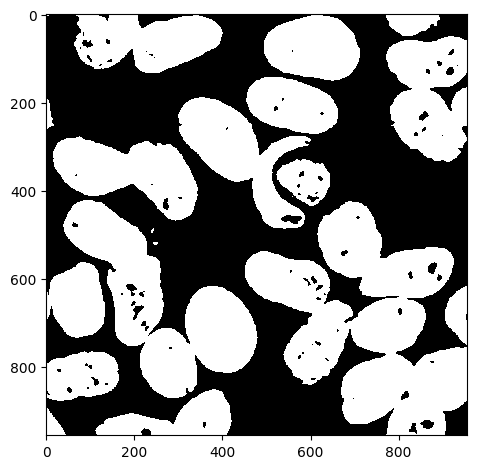

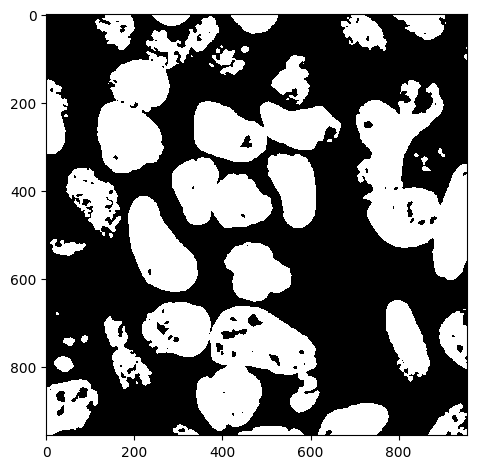

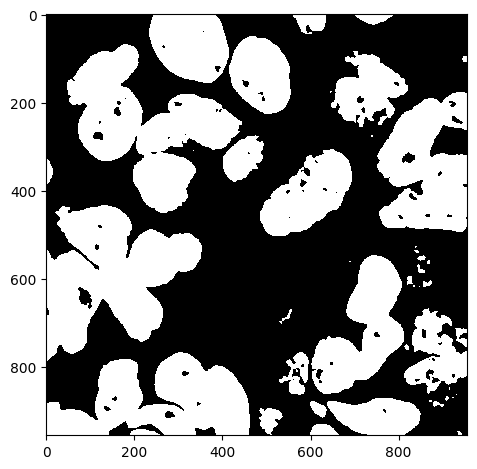

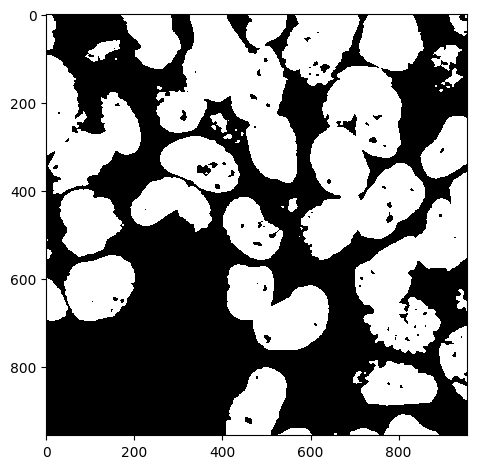

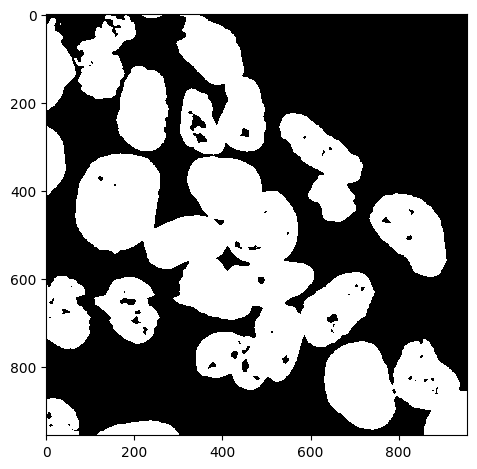

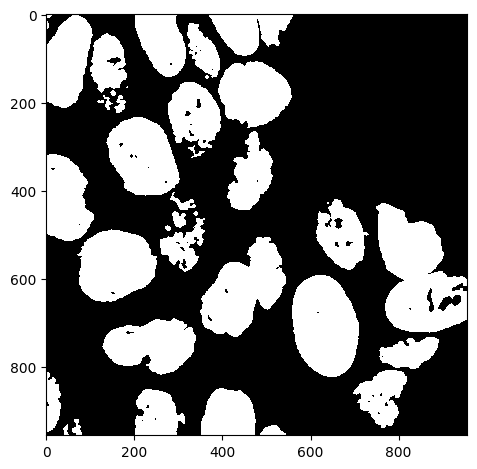

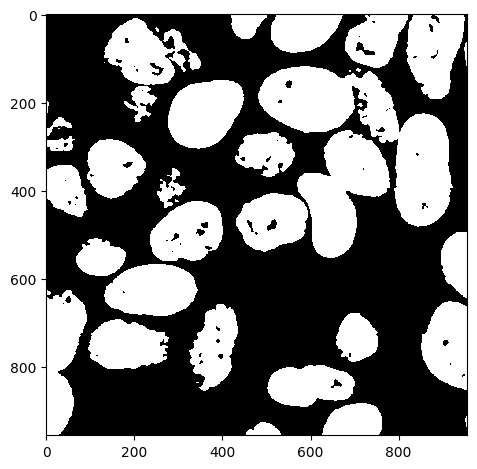

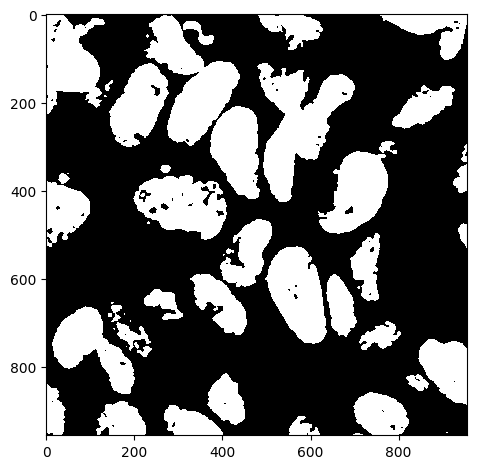

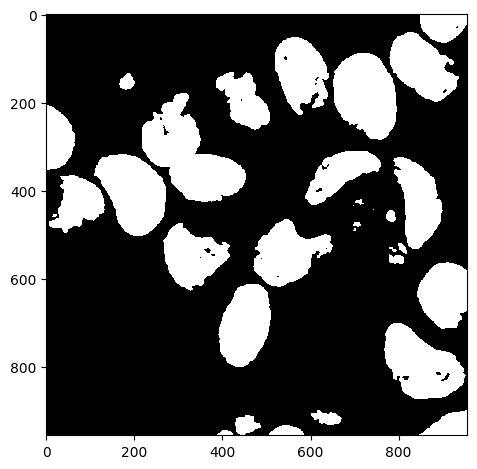

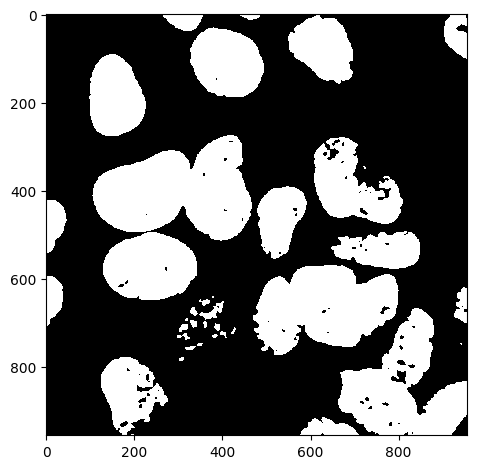

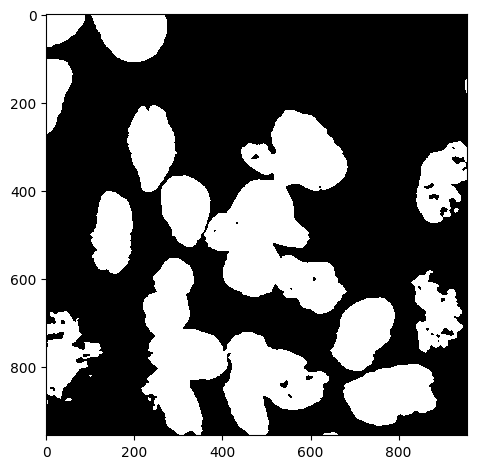

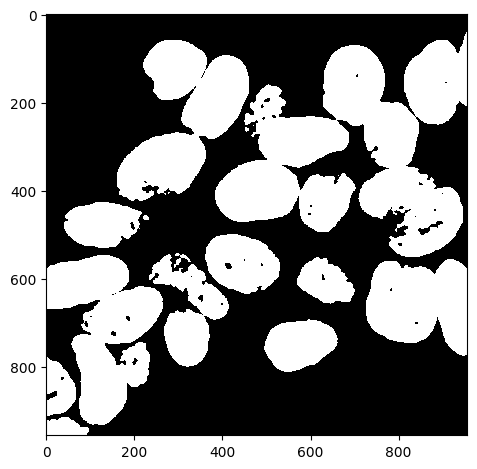

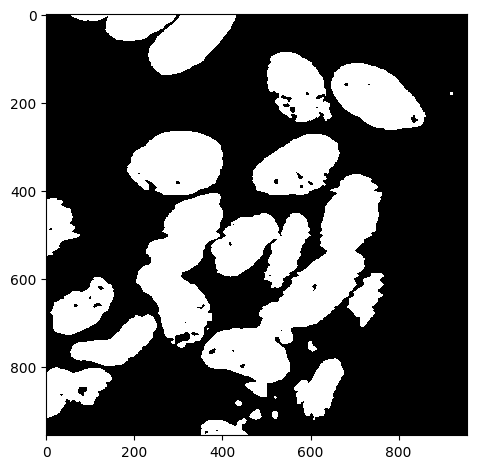

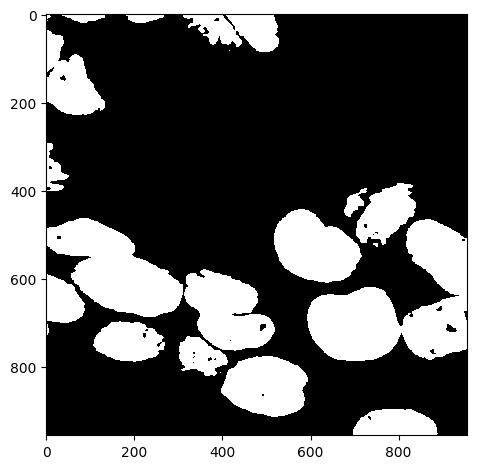

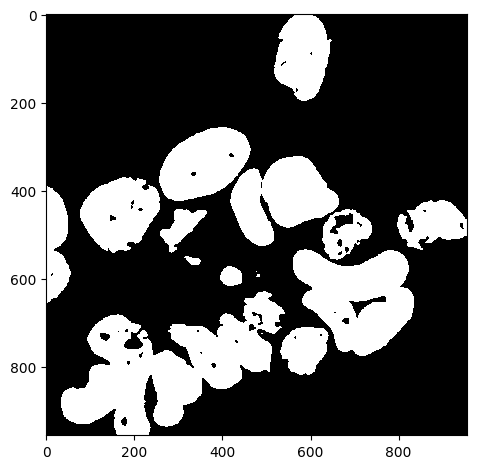

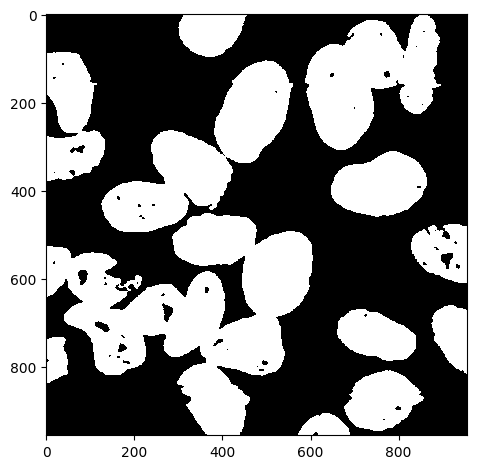

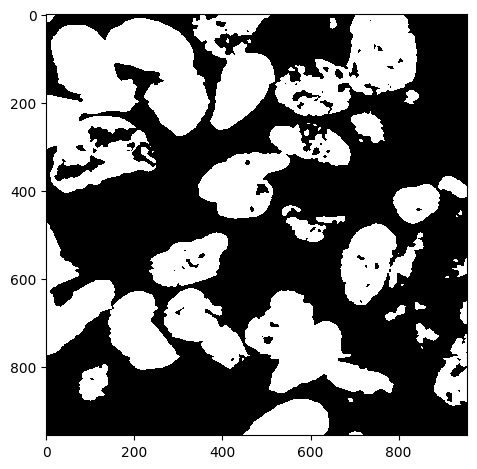

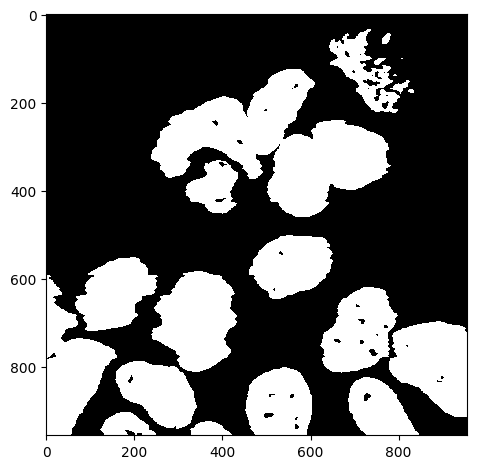

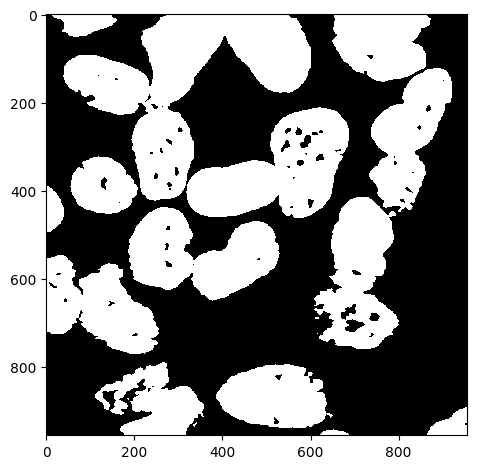

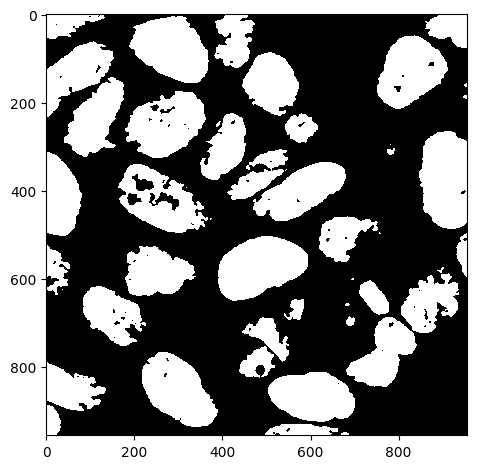

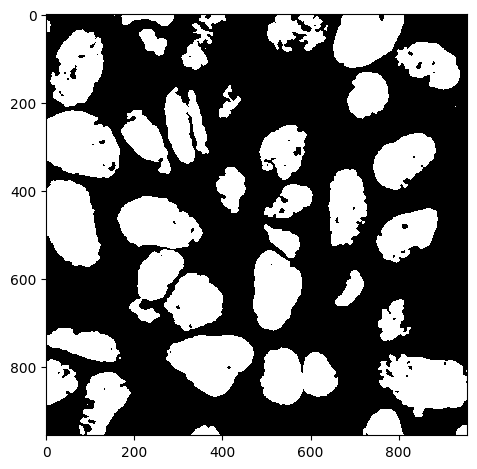

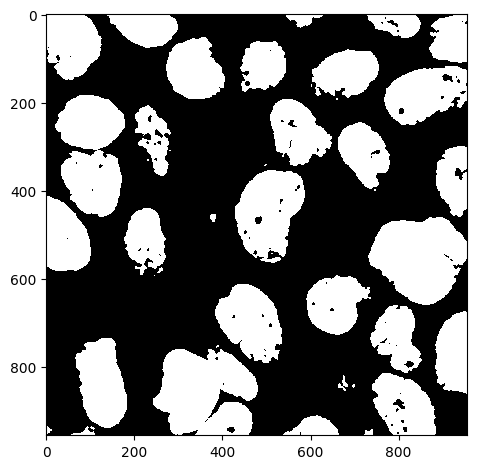

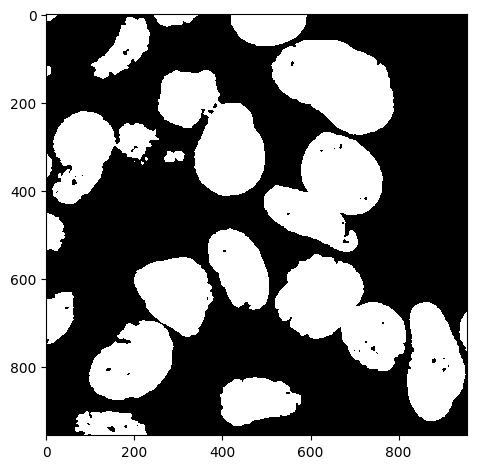

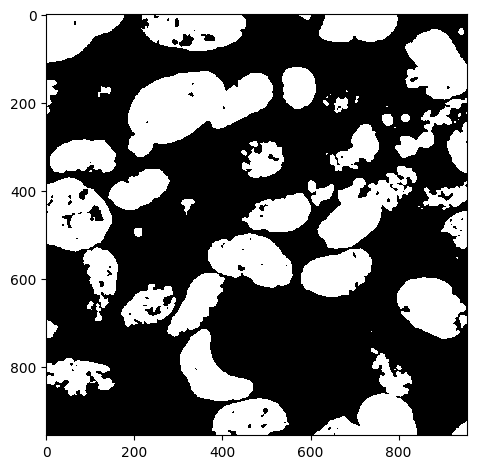

In [ ]:
def main(image_folder):
    # Initialize lists to store results
    surface_areas = []
    number_of_nuclei_list = []
    mean_sizes_of_inclusions = []
    sizes_df_new = None

    images_to_analyze = extract_image_paths(image_folder)

    # Iterate over each image
    for path in images_to_analyze:

        dapi_channel, green_channel, red_channel = read_czi_image(path)
        
        # Process red channel for surface area
        labeled_image_otsu = otsu_thresholding(red_channel)
        surface_area = calculate_surface_area(labeled_image_otsu, red_channel)
        surface_areas.append(surface_area)

        # Process DAPI channel for nuclei counting
        labeled_image_dapi = preprocess_dapi_channel(dapi_channel)

        n_nuclei = count_nuclei(labeled_image_dapi)
        number_of_nuclei_list.append(n_nuclei)

        # Process green channel for inclusion quantification
        confocal_img = preprocess_green_channel(green_channel)
        
        labeled_image_inclusions = threshold_inclusions(confocal_img)
        
        
        inclusion_sizes = measure_inclusion_sizes(labeled_image_inclusions, confocal_img)
        mean_sizes_of_inclusions.append(np.mean(inclusion_sizes))

        # Add to DataFrame
        sizes_df_new = add_to_dataframe(sizes_df_new, inclusion_sizes, os.path.basename(path))

    # Calculate metrics and save results
    excel_2 = calculate_metrics(surface_areas, number_of_nuclei_list, mean_sizes_of_inclusions, sizes_df_new)
    save_to_excel(sizes_df_new, excel_2)

if __name__ == "__main__":
    # image_folder = 'LysotrackerRed_mccc1_stk39_101824' # threshold = 0.875
    # main(image_folder)

    image_folder = 'LysotrackerRed_mccc1_stk39_102524' # threshold = 0.9
    main(image_folder)
